In [1]:
%autosave 60
%pip install --quiet -r requirements.txt

Autosaving every 60 seconds
Note: you may need to restart the kernel to use updated packages.


## Setup

In [2]:
import os
import numpy as np
import random
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.data_loader import DataLoader
from utils.data_converter import DataConverter
from models.unet_3d_std import ResidualUNet3D

data_loader = DataLoader()
data_converter = DataConverter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Flush cuda memory

In [3]:
torch.cuda.empty_cache()

Common Variables

In [4]:
model_epochs = 101
print_every = 25
save_every = 50

In [5]:
training_pairs, validation_pairs, test_pairs = data_loader.split_dataset_paths(seed=69) # Standard 70/20/10 split
print("We have", len(training_pairs), "training pairs")
print("We have", len(test_pairs), "test pairs")

We have 492 training pairs
We have 106 test pairs


## 3D U-Net

In [6]:
output_dir = "out/unets"
unet_path = f"{output_dir}/3d_unet_model_0.0580.pt"
unet = ResidualUNet3D(in_ch=1, base=32).to(device)
unet_optimizer = optim.AdamW(unet.parameters(), lr=1e-4, weight_decay=1e-5)

In [7]:
# Load existing model if it exists
if os.path.isfile(unet_path):
    print("Loading existing model")
    unet.load_state_dict(torch.load(unet_path))
else:
    print("No existing 3D U-Net found, starting fresh training.")
    os.makedirs(output_dir, exist_ok=True)
    
print(len(training_pairs), "training pairs")

No existing 3D U-Net found, starting fresh training.
492 training pairs


In [8]:
unet, unet_losses, unet_snapshots = fit_3D(
    model=unet,
    optimizer=unet_optimizer,
    device=device,
    dataLoader=data_loader,
    training_pairs=training_pairs,
    criterion=recon_loss,
    epochs=model_epochs,
    print_every=print_every,
    save_every=save_every
)

NameError: name 'fit_3D' is not defined

Displaying snapshot from pair 0, loss: 0.0692


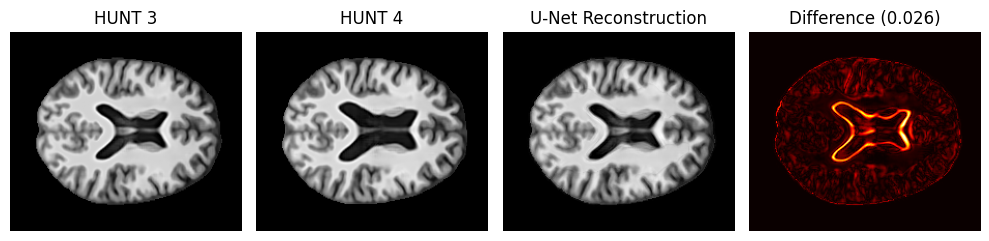

Displaying snapshot from pair 50, loss: 0.0683


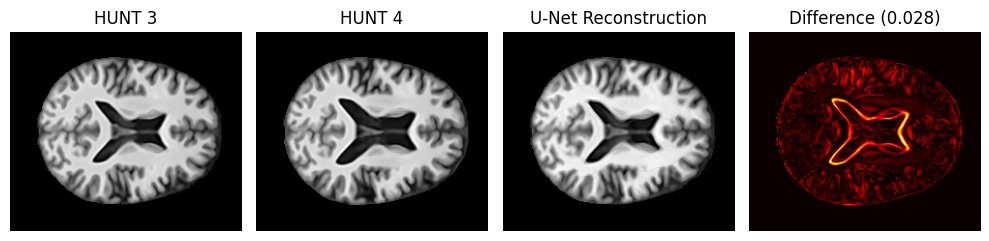

Displaying snapshot from pair 100, loss: 0.0641


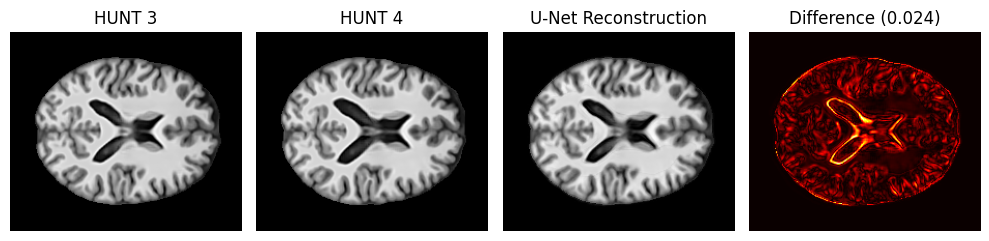

In [ ]:
for snapshot in unet_snapshots:
    print(f"Displaying snapshot from pair {snapshot['iter']}, loss: {snapshot['loss']:.4f}")
    difference = np.abs(snapshot["recon"] - snapshot["y"])
    data_loader.display_slices([snapshot["x"], snapshot["y"], snapshot["recon"], difference], slice_labels=["HUNT 3", "HUNT 4", "U-Net Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])

In [ ]:
# Save the final model to the /out directory
torch.save(unet.state_dict(), unet_path)
print(f"Model saved to {unet_path}")

Model saved to out/unet_models/3d_unet_model.pt


## MP-GAN

In [ ]:
output_dir = "out/mpgan_3d"
generator_path = f"{output_dir}/3d_mpgan_G_4.4.pt"
discriminator_path = f"{output_dir}/3d_mpgan_D_4.4.pt"

generator = Generator3D(in_channels=1, out_channels=1).to(device)
discriminator = Discriminator3D(in_channels=1).to(device)
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999))
base_enc = MiniEncoder3D(in_ch=1, chs=(16,32,64,128))   # Can swap with pretrained encoder
phi = PhiFeatureExtractor(base_enc).to(device)

In [ ]:
# Load existing model if it exists
if os.path.isfile(generator_path) and os.path.isfile(discriminator_path):
    print("Loading existing GAN models")
    generator.load_state_dict(torch.load(generator_path)) 
    discriminator.load_state_dict(torch.load(discriminator_path))
else:
    print("No existing GAN models found, starting fresh training.")
    os.makedirs(output_dir, exist_ok=True)
    
print(len(training_pairs), "training pairs")

Loading existing GAN models
562 training pairs


In [ ]:
# Use with fit_3D
generator, discriminator, gan_losses, gan_snapshots = fit_3D_gan(
    G=generator,
    D=discriminator,
    device=device,
    dataLoader=data_loader,
    training_pairs=training_pairs,
    epochs=model_epochs,
    lr_G=1e-4,
    lr_D=1e-4,
    opt_G=generator_optimizer,
    opt_D=discriminator_optimizer, 
    trim_slices=0,
    crop_size=(193,229),
    phi=phi,
    print_every=print_every,
    save_every=save_every
)

[Iter 0] D_total=0.2114 G_total=25.2419 L1=0.2575 Perc=0.6934 AdvG=1.4692
Saved snapshot at iter 0
[Iter 25] D_total=0.1937 G_total=23.8338 L1=0.2491 Perc=0.6329 AdvG=1.7828
[Iter 50] D_total=0.1764 G_total=23.9693 L1=0.2424 Perc=0.6420 AdvG=1.8581
Saved snapshot at iter 50
[Iter 75] D_total=0.1567 G_total=22.7644 L1=0.2349 Perc=0.5982 AdvG=1.9380
[Iter 100] D_total=0.1418 G_total=24.1413 L1=0.2327 Perc=0.6507 AdvG=2.0558
Saved snapshot at iter 100


Displaying snapshot from pair 0


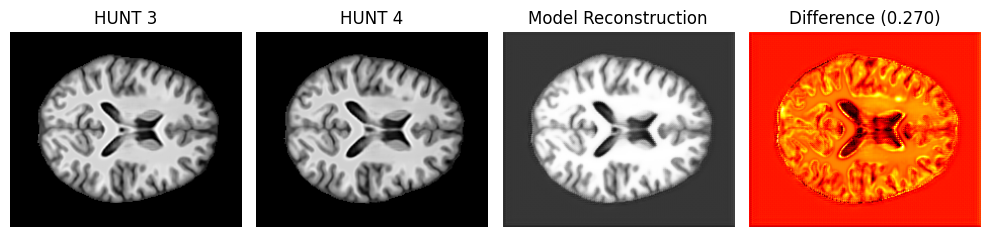

Displaying snapshot from pair 50


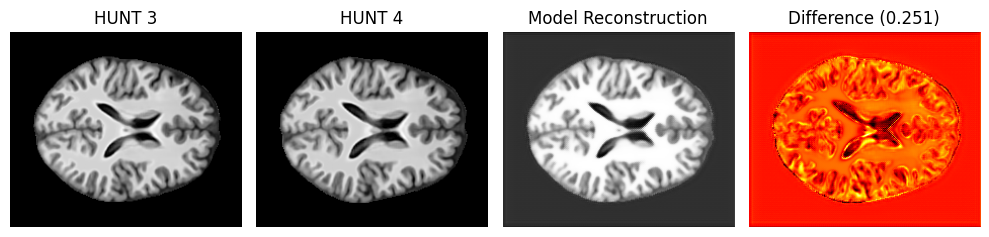

Displaying snapshot from pair 100


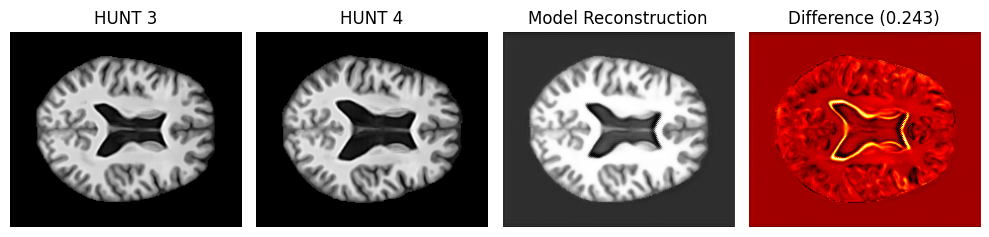

In [ ]:
for snapshot in gan_snapshots:
    print(f"Displaying snapshot from pair {snapshot['iter']}")
    difference = np.abs(snapshot["recon"] - snapshot["y"])
    data_loader.display_slices([snapshot["x"], snapshot["y"], snapshot["recon"], difference], slice_labels=["HUNT 3", "HUNT 4", "Model Reconstruction", f"Difference ({np.mean(difference):.3f})"], slice_colors=["gray", "gray", "gray", "hot"])

In [ ]:
# Save the final model to /out directory
torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)
print(f"Generator saved to {generator_path}")
print(f"Discriminator saved to {discriminator_path}")

Generator saved to out/gan_models/3d_mpgan_model_G.pt
Discriminator saved to out/gan_models/3d_mpgan_model_D.pt


## Display evenly spaced results from both models

In [ ]:
test_images = 4

# Same split as during training
training_pairs, test_pairs = data_loader.split_training_test_paths(seed=69)
print("We have", len(training_pairs), "training pairs")
print("We have", len(test_pairs), "test pairs")

We have 562 training pairs
We have 141 test pairs


Displaying results for test image 127, slice 15


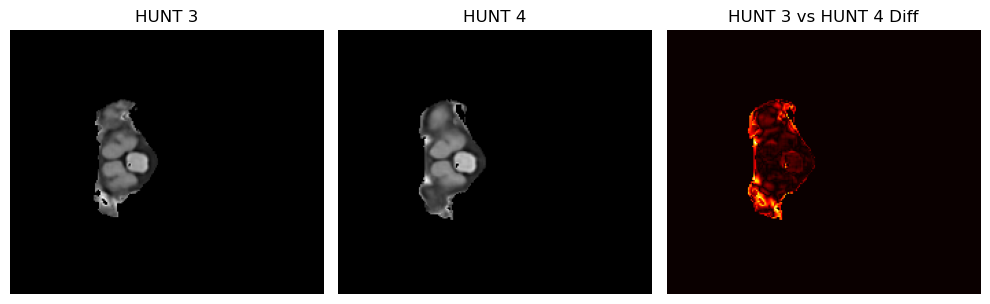

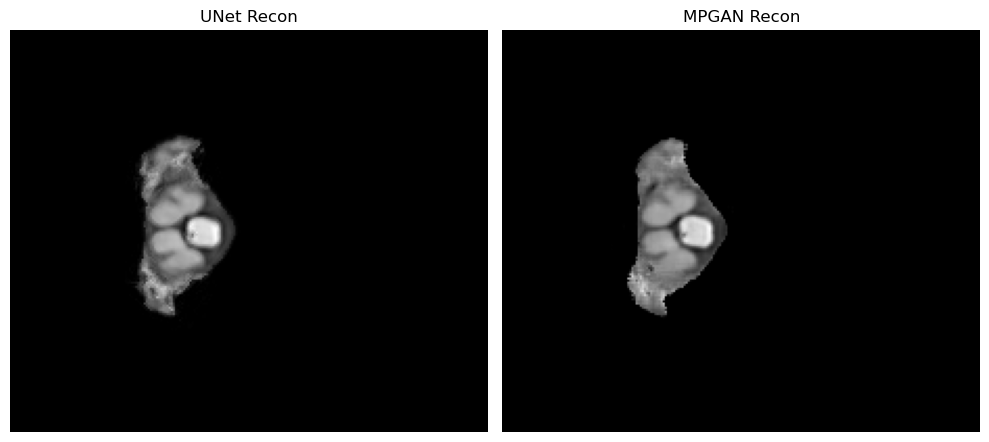

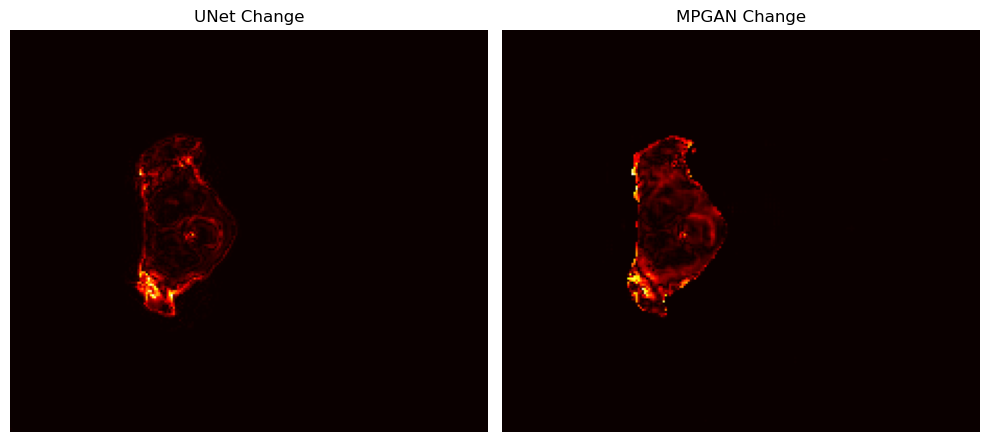

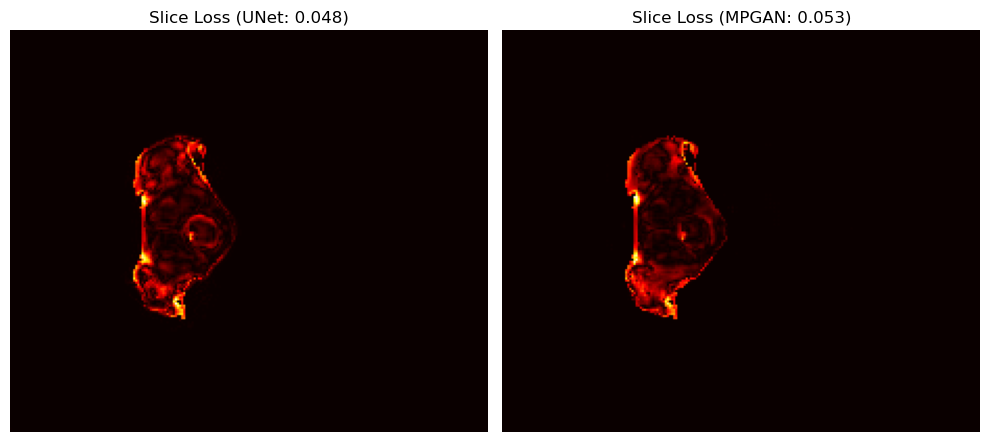

Displaying results for test image 51, slice 55


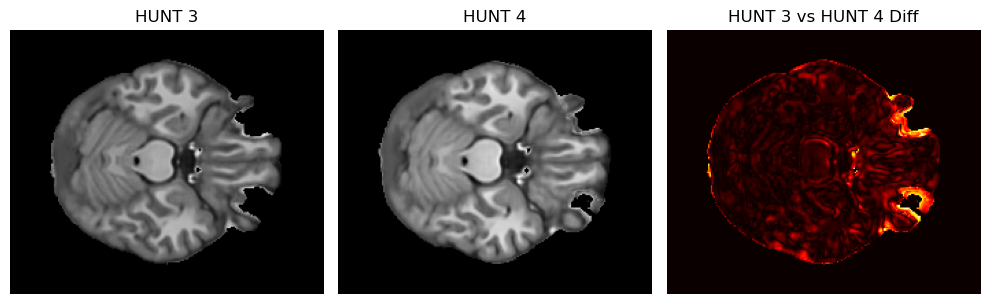

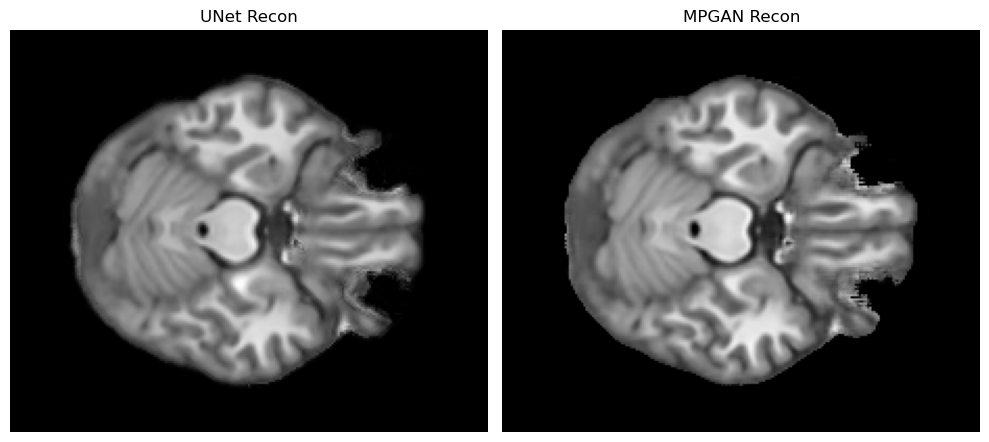

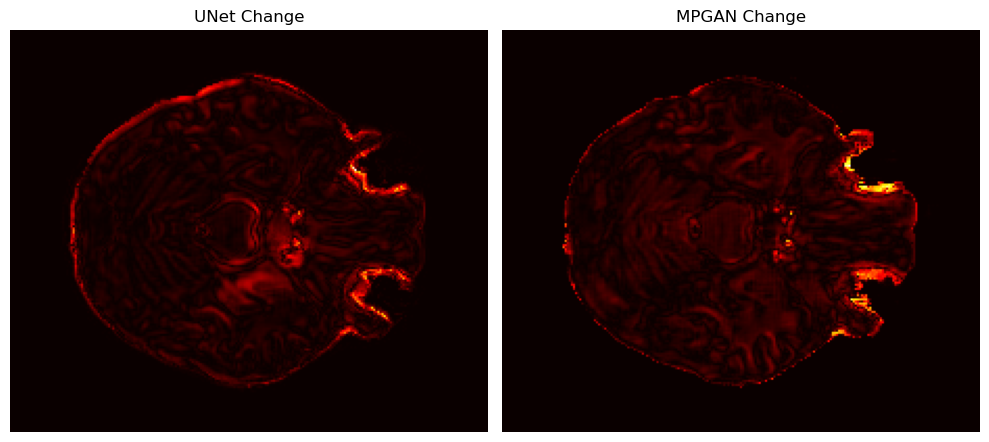

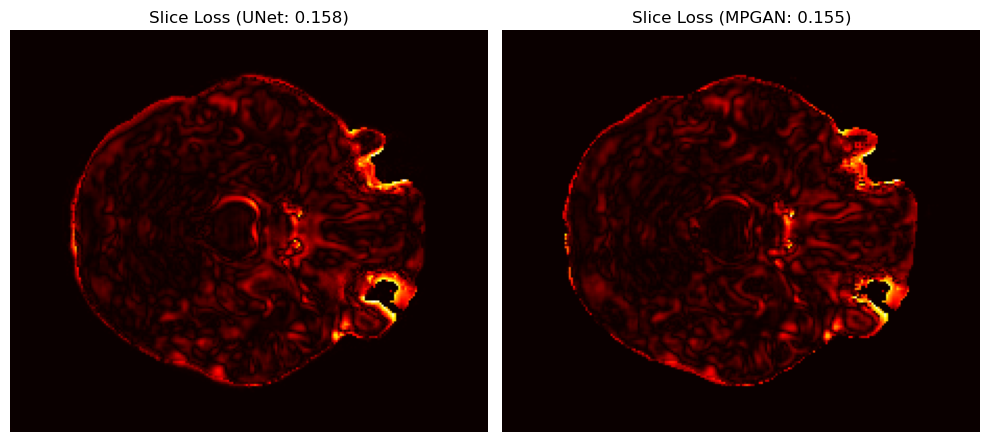

Displaying results for test image 128, slice 96


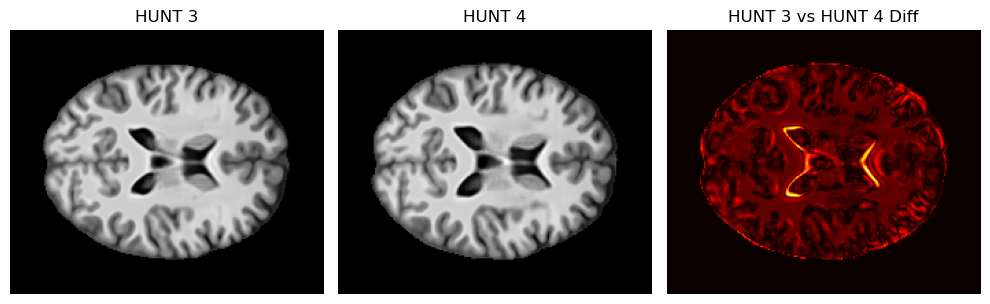

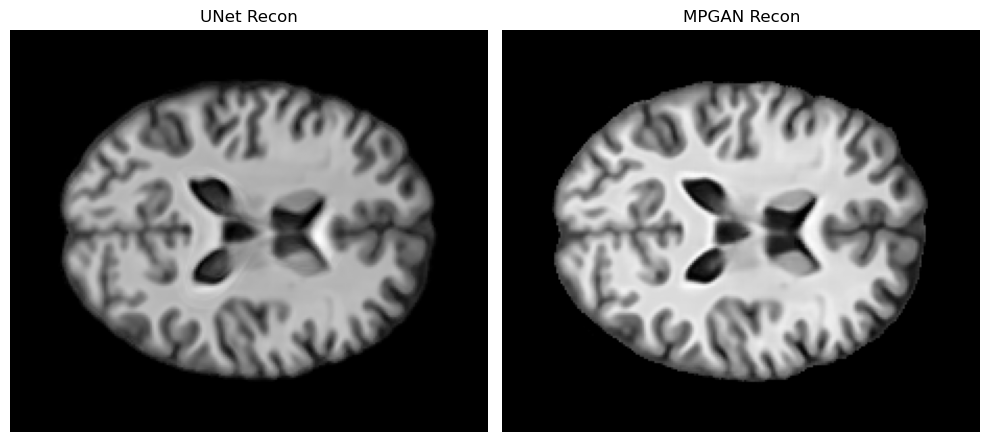

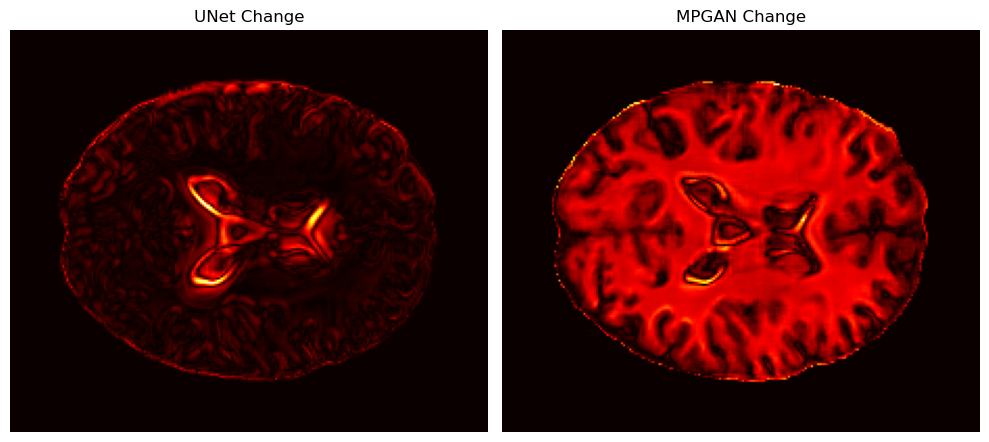

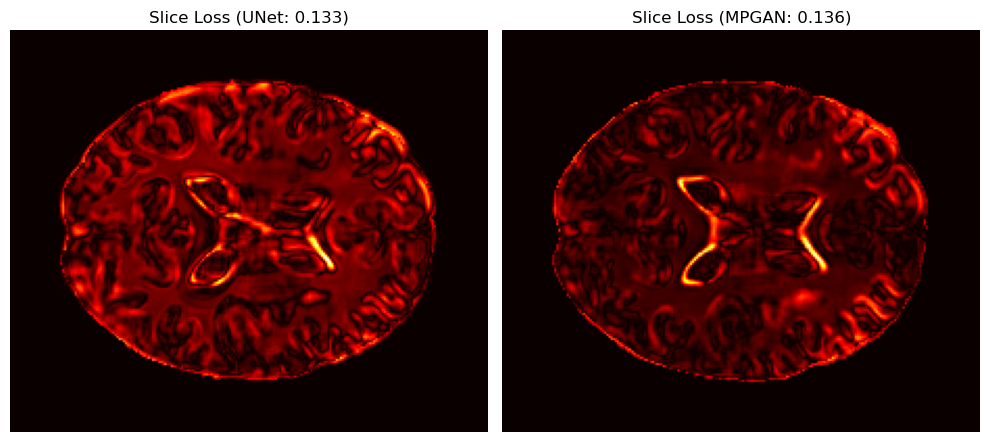

Displaying results for test image 64, slice 137


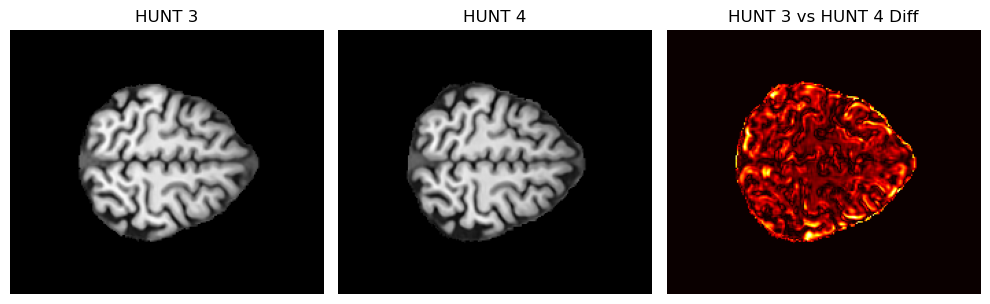

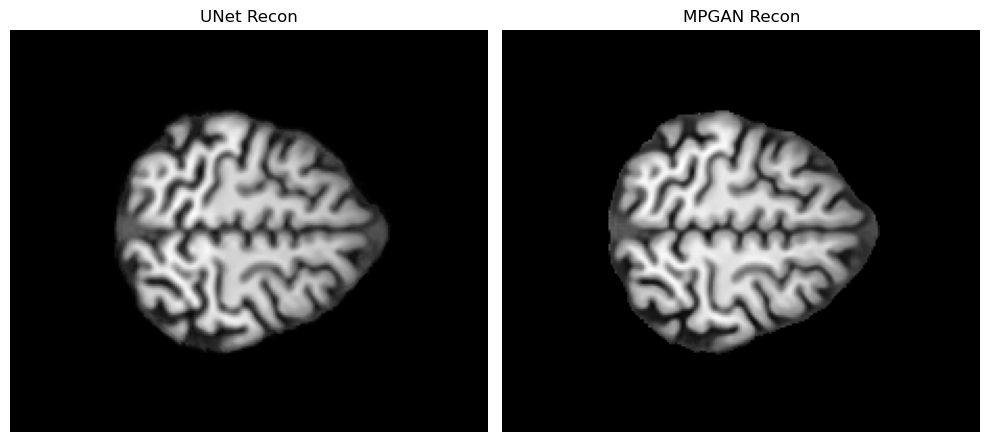

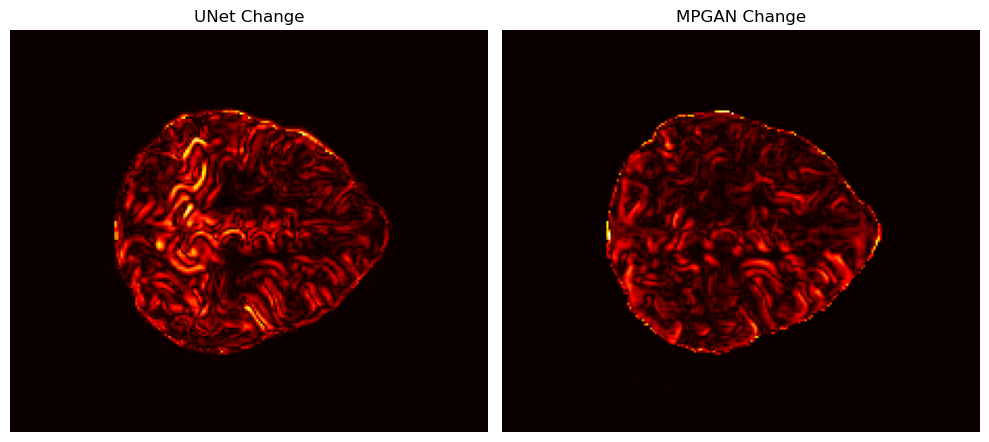

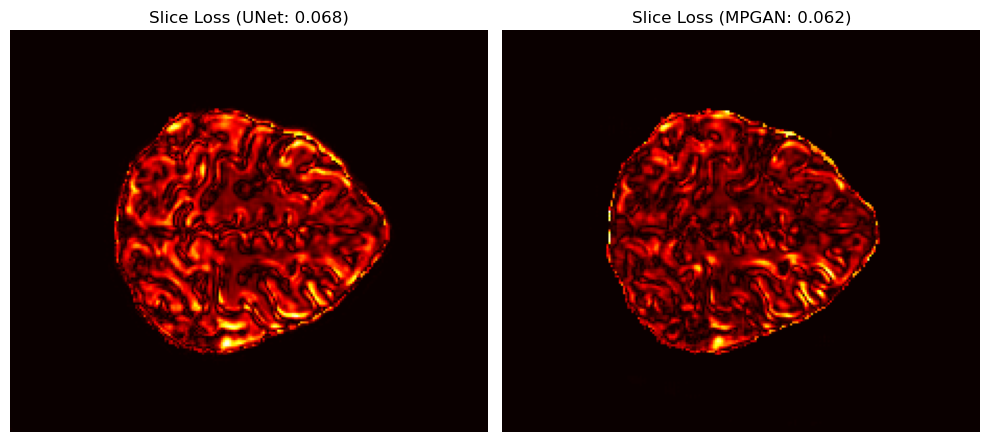

In [ ]:
unet.eval()
generator.eval()

for i in range(test_images):
    candidate = random.randint(0, len(test_pairs) - 1)

    # Load volumes as numpy
    input_np  = data_loader.load_from_path(test_pairs[candidate][0])
    target_np = data_loader.load_from_path(test_pairs[candidate][1])

    depth = input_np.shape[2] # This is to get top-bottom slices
    padding = 15
    slice_idx = int(padding + i * ((depth - 2 * padding) / test_images))

    # Turn input and target into tensors for models:
    input_tensor  = torch.from_numpy(input_np).float()[None, None].to(device)
    target_tensor = torch.from_numpy(target_np).float()[None, None].to(device)

    # Get reconstructions as tensors
    unet_recon_tensor, _ = unet(input_tensor)      
    mpgan_recon_tensor   = generator(input_tensor) 

    # Convert to numpy
    unet_recon_np  = unet_recon_tensor.detach().cpu().squeeze().clamp(0, 1).numpy()
    mpgan_recon_np = mpgan_recon_tensor.detach().cpu().squeeze().clamp(0, 1).numpy()

    # Get the correct slice of the model outputs
    input_slice_np  = input_np[..., slice_idx]
    target_slice_np = target_np[..., slice_idx]
    unet_slice_np   = unet_recon_np[..., slice_idx]
    mpgan_slice_np  = mpgan_recon_np[..., slice_idx]

    # How much the models changed from the input
    change_unet  = np.abs(unet_slice_np  - input_slice_np)
    change_mpgan = np.abs(mpgan_slice_np - input_slice_np)

    # Difference between reconstructions and ground truth
    diff_unet  = np.abs(unet_slice_np  - target_slice_np)
    diff_mpgan = np.abs(mpgan_slice_np - target_slice_np)
    hunt_diff  = np.abs(input_slice_np - target_slice_np)

    # To get the slice-wise error we use the tensors directly
    unet_slice_tensor   = unet_recon_tensor[..., slice_idx]
    mpgan_slice_tensor  = mpgan_recon_tensor[..., slice_idx]
    target_slice_tensor = target_tensor[..., slice_idx]

    pred_error_unet  = ssim_L1_2d_loss(unet_slice_tensor,  target_slice_tensor).item()
    pred_error_mpgan = ssim_L1_2d_loss(mpgan_slice_tensor, target_slice_tensor).item()

    print(f"Displaying results for test image {candidate}, slice {slice_idx}")


    # ------------------ Visualizations ------------------

    # HUNT 3, HUNT 4, and their difference
    data_loader.display_slices(
        slices=[input_slice_np, target_slice_np, hunt_diff],
        slice_labels=["HUNT 3", "HUNT 4", "HUNT 3 vs HUNT 4 Diff"],
        slice_colors=["gray", "gray", "hot"]
    )

    # The two models’ outputs (per slice)
    data_loader.display_slices(
        slices=[unet_slice_np, mpgan_slice_np],
        slice_labels=["UNet Recon", "MPGAN Recon"],
        slice_colors=["gray", "gray"]
    )

    # The two models’ change from HUNT 3
    data_loader.display_slices(
        slices=[change_unet, change_mpgan],
        slice_labels=["UNet Change", "MPGAN Change"],
        slice_colors=["hot", "hot"]
    )

    # The two models’ difference from HUNT 4, with slice-wise loss in labels
    data_loader.display_slices(
        slices=[diff_unet, diff_mpgan],
        slice_labels=[
            f"Slice Loss (UNet: {pred_error_unet:.3f})",
            f"Slice Loss (MPGAN: {pred_error_mpgan:.3f})",
        ],
        slice_colors=["hot", "hot"]
    )


## Estimate Accuracy over testset

In [ ]:
unet.eval()
generator.eval()

avg_unet_loss = 0.0
avg_mpgan_loss = 0.0

# Estimate Accuracy over testset
for (input_path, target_path) in tqdm(test_pairs):
    # Import image from paths
    input, target = data_loader.load_from_path(input_path), data_loader.load_from_path(target_path)

    # We must turn input and target into 3D tensors fro the models
    input_tensor, target_tensor = torch.from_numpy(input).float()[None, None].to(device), torch.from_numpy(target).float()[None, None].to(device)

    # Get Reconstructions
    unet_recon, mpgan_recon = unet(input_tensor)[0], generator(input_tensor)

    # calculate 3d loss
    avg_unet_loss += recon_loss(unet_recon, target_tensor).item()
    avg_mpgan_loss += recon_loss(mpgan_recon, target_tensor).item()

avg_unet_loss /= len(test_pairs)
avg_mpgan_loss /= len(test_pairs)

print(f"Average U-Net 3D Loss over Test Set: {avg_unet_loss:.4f}")
print(f"Average MPGAN 3D Loss over Test Set: {avg_mpgan_loss:.4f}")

100%|██████████| 141/141 [02:12<00:00,  1.06it/s]

Average U-Net 3D Loss over Test Set: 0.0689
Average MPGAN 3D Loss over Test Set: 0.0706
